## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [5]:
import glob
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def BandpassFilter(signal, fs=125):
    """
    Bandpass filter the signal between 70 and 190 BPM.
    """
    b, a = sp.signal.butter(3, (70/60, 190/60), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)


def fft(sig, fs):
    freqs = np.fft.rfftfreq(len(sig), 1/fs)
    fft_mag = np.abs(np.fft.rfft(sig))
    return (freqs, fft_mag)


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability.

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and
        corresponding reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse
        rate error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an
    aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return (AggregateErrorMetric(errs, confs), errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Args:
        data_fl: (str) filepath to a troika .mat file (signal).
        ref_fl: (str) filepath to a troika .mat file (ground truth heart rate).

    Returns:
        pr_errors: a numpy array of errors between pulse rate estimates and
        corresponding reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse
        rate error.
    """
    fs = 125

    # Load ground truth heart rate
    ref_hrs = sp.io.loadmat(ref_fl)['BPM0']

    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    acc = np.mean([accx, accy, accz], axis=0)
    data_list = [ppg, acc]
    label_list = ['ppg', 'acc']

    # Bandpass filter the signal between 70 and 190 BPM
    filtered = {label: BandpassFilter(data) for (
        label, data) in zip(label_list, data_list)}

    # Move with a window_length_s of 8s and the window_shift_s of 2s
    # The ground truth data follows the same cadence
    errors, confidence = [], []
    window_length_s = 8
    window_shift_s = 2
    window_length = window_length_s * fs
    window_shift = window_shift_s * fs
    idx = list(range(0, len(ppg) - window_length, window_shift))
    for i in idx:
        segments = {label: filtered[label][
            i: i + window_length] for label in label_list}

        freqs, mags, sorted_inds, sorted_freqs = {}, {}, {}, {}
        for label in label_list:
            freqs[label], mags[label] = fft(segments[label], fs)
            sorted_inds[label] = np.argsort(mags[label])[::-1][:4]
            sorted_freqs[label] = freqs[label][sorted_inds[label]]

        try:
            est_f = [freq for freq in sorted_freqs['ppg']
                     if freq not in sorted_freqs['acc']][0]

        except:
            ind = sorted_inds['ppg'][0]
            est_f = freqs['ppg'][ind]

        est_hr = est_f * 60
        ref_hr = ref_hrs[idx.index(i)][0]
        errors.append(np.mean(np.abs(est_hr-ref_hr)))
        confidence.append(np.sum(mags['ppg'][(freqs['ppg'] >= est_f-30/60) & (
                    freqs['ppg'] <= est_f+30/60)]) / np.sum(mags['ppg']))
    return np.array(errors), np.array(confidence)

In [6]:
metric, errs, confs = Evaluate()

In [7]:
metric, errs, confs

(15.524581670768509,
 array([ 0.66079295, 73.64253394, 72.85714286, ...,  1.25      ,
         2.0596    ,  3.4959    ]),
 array([0.24903011, 0.41299814, 0.36893269, ..., 0.50129254, 0.45931348,
        0.61057147]))

# Failure Mode

In [8]:
data_fls, ref_fls = LoadTroikaDataset()
data_fls, ref_fls

(['./datasets/troika/training_data/DATA_01_TYPE01.mat',
  './datasets/troika/training_data/DATA_02_TYPE02.mat',
  './datasets/troika/training_data/DATA_03_TYPE02.mat',
  './datasets/troika/training_data/DATA_04_TYPE01.mat',
  './datasets/troika/training_data/DATA_04_TYPE02.mat',
  './datasets/troika/training_data/DATA_05_TYPE02.mat',
  './datasets/troika/training_data/DATA_06_TYPE02.mat',
  './datasets/troika/training_data/DATA_07_TYPE02.mat',
  './datasets/troika/training_data/DATA_08_TYPE02.mat',
  './datasets/troika/training_data/DATA_10_TYPE02.mat',
  './datasets/troika/training_data/DATA_11_TYPE02.mat',
  './datasets/troika/training_data/DATA_12_TYPE02.mat'],
 ['./datasets/troika/training_data/REF_01_TYPE01.mat',
  './datasets/troika/training_data/REF_02_TYPE02.mat',
  './datasets/troika/training_data/REF_03_TYPE02.mat',
  './datasets/troika/training_data/REF_04_TYPE01.mat',
  './datasets/troika/training_data/REF_04_TYPE02.mat',
  './datasets/troika/training_data/REF_05_TYPE02.mat

In [9]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
ppg, accx, accy, accz

(array([  4. ,   6. ,   3. , ...,  86. , 104. , 118.5]),
 array([-0.0702, -0.0702, -0.0546, ...,  0.4134,  0.4134,  0.4134]),
 array([ 0.3432,  0.3588,  0.3666, ..., -0.2808, -0.273 , -0.273 ]),
 array([0.9594, 0.9438, 0.936 , ..., 0.7254, 0.7176, 0.7254]))

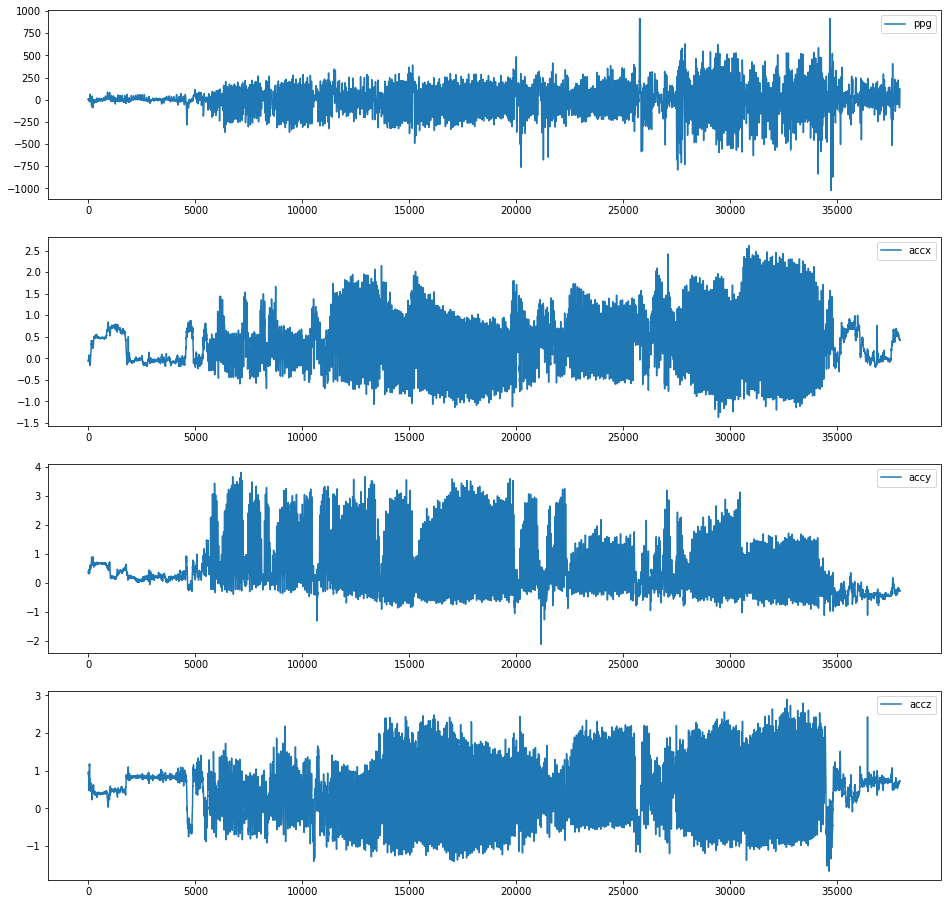

In [10]:
data_list = [ppg, accx, accy, accz]
label_list = ['ppg', 'accx', 'accy', 'accz']

figs, axes = plt.subplots(4, figsize=(16, 16))
for i, ax in enumerate(axes):
    axes[i].plot(data_list[i], label = label_list[i])
    axes[i].legend(loc='upper right')

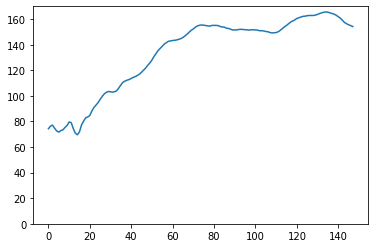

In [11]:
# BPM value in every 8-second time window. 
# Two successive time windows overlap by 6 seconds. 
# The first value in 'BPM0' gives the calcualted heart rate ground-truth in the first 8 seconds, 
# The second value in 'BPM0' gives the calculated heart rate ground-truth from the 3rd second to the 10th second
ref = sp.io.loadmat(ref_fls[0])['BPM0']
plt.plot(ref)
plt.ylim(0, 170);
ref_hr = np.mean(ref)

In [12]:
np.argsort(errs[:148])

array([143, 111,  46,  38, 117,  39,   8, 110,  12,  50, 131, 109,   0,
       104,  37, 144,  40, 112, 130,  97,  45,  89,   7, 142,  96,  91,
        49,  98, 129,  52,  36,  47, 119,  92, 139,  41,  14,   6, 128,
       126,  20,  54,  17,  73, 125,  80,  81, 146, 113,  72, 140, 147,
       122,   5,  51, 121,  48,  15,  78,  10,  86,  87, 124,  82, 145,
        21,  95, 138, 105, 133, 107, 108, 103, 101, 100,  11,  13,  79,
        88,  93,  18,  56,  55,  77,  94, 118,  19,  61,  53, 106,  57,
       102,  65,  64,  99,  30,  31,  28,  44,  43,  16,  33, 141,  85,
        35,  34,  66,  42,  58,  59,  60,  84,  83,  67,  68,  62,  69,
        63,  70, 120,  71, 114,  76,  75,  74,   9,  90,  29,  32,  27,
       123, 115,  26,   2, 127,   1, 116, 137, 132, 136,  25, 135, 134,
        24,  23,  22,   3,   4])

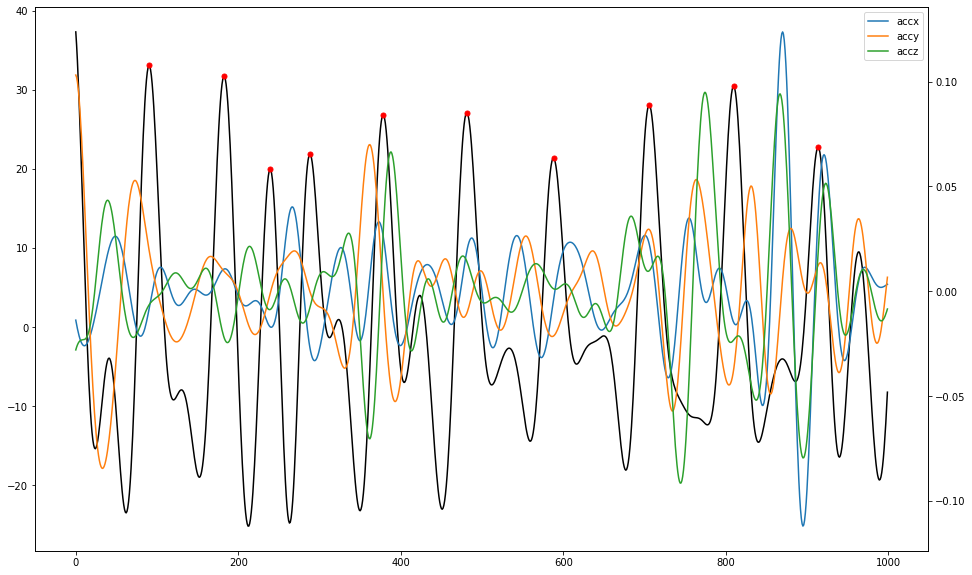

In [13]:
fs = 125
filtered = {label : BandpassFilter(data) for (label, data) in zip(label_list, data_list)}
ppg_seg = filtered['ppg'][1000:2000]
pks = sp.signal.find_peaks(ppg_seg, height=15, distance=35)[0]

fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()

ax1.plot(ppg_seg, 'black')
ax1.plot(pks, ppg_seg[pks], 'r.', ms=10)

for label in label_list[1:]:
    ax2.plot(filtered[label][1000:2000], label=label)
    ax2.legend(loc='upper right')

plt.show()

In [14]:
acc = np.mean([accx, accy, accz], axis =0)
data_list = [ppg, acc]
label_list = ['ppg', 'acc']

filtered = {label : BandpassFilter(data) for (label, data) in zip(label_list, data_list)}
errors, confidence = [], []

# Load ground truth heart rate
ref_hrs = sp.io.loadmat(ref_fls[0])['BPM0']

window_length_s = 8
window_shift_s = 2
window_length = window_length_s * fs
window_shift = window_shift_s * fs
idx = list(range(0, len(ppg) - window_length, window_shift))
i = idx[4]

segments = {label:filtered[label][i: i + window_length] for label in label_list}

freqs, mags, sorted_inds, sorted_freqs = {}, {}, {}, {}
for label in label_list:
    freqs[label], mags[label] = fft(segments[label], fs)
    sorted_inds[label] = np.argsort(mags[label])[::-1][:4]
    sorted_freqs[label] = freqs[label][sorted_inds[label]]

try:
    est_f = [freq for freq in sorted_freqs['ppg'] if freq not in sorted_freqs['acc']][0]

except:
    ind = sorted_inds['ppg'][0]
    est_f = freqs['ppg'][ind]

est_hr = est_f * 60
ref_hr = ref_hrs[idx.index(i)][0]
errors.append(np.mean(np.abs(est_hr-ref_hr))) 
confidence.append(np.sum(mags['ppg'][(freqs['ppg']>=est_f-30/60) & (freqs['ppg']<=est_f+30/60)])/ np.sum(mags['ppg']))

In [15]:
print(est_hr/60, ref_hr/60)
print(sorted_freqs['ppg'])
print(sorted_freqs['acc'])

2.625 1.2096774193548387
[1.25  2.625 2.375 2.25 ]
[2.25  1.625 1.25  2.5  ]


-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

# **Project Summary**

**Code Desription**

This code estimates the pulse rate from the PPG signal and a 3-axis accelerometer. The pulse rate is restricted between 70BPM (beats per minute) and 190BPM. It produces an estimation confidence. A higher confidence value means that this estimate should be more accurate than an estimate with a lower confidence value. The code produces an output every 2 seconds. 

**Data Description**

Trioka dataset is used for this algorithm.

*Activitiy:* Data were recorded during activities including rest, jog, and run at various speeds.

*Features of sensor:* ECG sensor generated signal with one channel; PPG sensor generated two signals from each wrist; The accelerometer generated signals with three channels (x, y and z).

*Short-coming:* Data were recorded on fixed actions, not in a free-living context.

**Algorithhm Description**

*1. How the algorithm works:*

When the dominant accelerometer frequency is the same as the PPG, I pick the next strongest PPG frequency if there is another good candidate. Sometimes the cadence of the arm swing is the same as the heartbeat. So if I can't find another good candidate pulse rate outside of the accelerometer peak, I choose the same as the accelerometer. The confidence algorithm sums the frequency magnitude near the pulse rate estimate and divides it by the sum of the entire magnitude, and thus produces a higher number for better estimates.  

*2. The specific aspects of the physiology that it takes advantage of:*

When the capilaries in the wrist are filled with blood, the light emitted by the PPG sensor is absorbed by red blood cells in these capilaries and the photodetector will see the drop in reflected light. When the blood returns to the heart, the photodetector sees an increase in reflected light. The pulse rate can be calculated based on this pattern. 

Activities lead to another periodic signal in the PPG due to the arm motion. The pulse rate estimator needs to distinguish this periodic signal from the pulse rate. I used the accelerometer signal of the wearable device to help keep track of which periodic signal is caused by motion. Because the accelerometer is only sensing arm motion, any periodic signal in the accelerometer is likely not due to the heart beating, and only due to the arm motion. If the pulse rate estimator is picking a frequency that's strong in the accelerometer, it may be making a mistake.

*3. A describtion of the algorithm outputs:*

A numpy array of errors between pulse rate estimates and corresponding reference heart rates and a numpy array of confidence estimates for each pulse rate error. 

*4. Caveats on algorithm outputs:*

The confidence algorithm sums the frequency magnitude near the pulse rate estimate and divides it by the sum of the entire magnitude. However, the signal could be generated by arm motion too. 

*5. Common failure modes:*

Sometimes, the strongest PPG frequency is the actual heart rate. However, the cadence of the arm swing is the same as the heartbeat. As a result, that PPG frequency is ruled out.  

**Algorithm Performance** 

Confidence estimates can be used to set the point on the error curve that I want to operate at by sacrificing the number of estimates that are considered valid. There is a trade-off between availability and error. For example if I want to operate at 90% availability, I look at the training dataset to determine the condince threshold for which 90% of the estimates pass. Then if only an estimate's confidence value is above that threshold do I consider it valid. The mean absolute error at 90% availability is 13.7 BPM on the test set because the data were recorded on fixed actions, not in a free-living context. 

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 